In [ ]:
import os
import glob
import random
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
from math import log,e,sqrt
from itertools import chain, compress
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Math

# Measuring peakiness

We want to look at the 'peakiness' of the distribution of PMI values for a given word.  Given a PMI matrix, where each row corresponds the the PMI of a given word with all the other words in the sentence, define peakiness as a function of a row of PMI values. $\text{peakiness}: \mathbb R^d \to \mathbb{R}[0,1]$


## Peakiness based on entropy
One intuitive measure is to make a length-dependent version of (inverse) entropy:
$$
\text{peakiness}(v) 
= 1 - \frac{S(v) }{ \log(d) }
$$
where 
$$
S(v) = -\sum_{i \in v} 
\frac i {\sum_{j \in v} j} \log(\frac i {\sum_{j \in v} j}),
$$
the entropy of the row, normalized, treated as a probability vector.

In [ ]:
def entropy(vec, base=None):
    """ Computes entropy of unnormalized vector of floats. """
    total = sum(vec)
    probs = [i / total for i in vec]
    entropy = 0.
    base = e if base is None else base
    for p in probs:
        if p < 0:
            ent_p = np.inf
        elif p == 0:
            ent_p = 0.
        else:
            ent_p = p * log(p, base)
        entropy -= ent_p

    return entropy

In [ ]:
# examples
def peakiness_entropy(vec, absolute=False):
    if len(vec) <= 1:
        return np.nan
    if absolute:
        vec = [abs(x) for x in vec]
    return 1 - entropy(vec) / log(len(vec))

# show examples
examples = ([1,0,0,0],[0,0,1,1],[0,0,10,10],[0,1,1,3],[1,1,1,1],
            [1,1,1,-1],[1],[0],[],
            [0,1,1],[0,1,1,0,0],[0,1,1,0,0,0,0,0,0])

# display(Math(r"\text{peakiness_entropy}: \mathbb{R}^d \to \mathbb{R}[0,1]"))
# for pmi_vec in examples:
#     display(Math(rf"{pmi_vec} \mapsto {peakiness_entropy(pmi_vec)}"))

One issue, however, if we are going to treat a sequence of PMI scores as a probability vector, is that PMI may be negative.  An intuitive way to do this still eludes me.  Shifting the values by the minimum value will not preserve the intuitive peakiness (for instance, taking $[0,0,0,-2]$ to $[2,2,2,0]$ becomes much 'flatter' than it should).  Taking the absolute value is better, but also doesn't seem right, since the distinction between positive and negative is meaningful (in taking $[0,0,1,-1]$ to $[0,0,1,1]$, we lose the information that the penultimate position has the maximum PMI).

So, with absolute value:

In [ ]:
# examples with abs
display(Math(r"\text{peakiness_entropy_abs}: \mathbb{R}^d \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_entropy(pmi_vec, absolute=True)}"))


## Peakiness as "sparseness"

Another option, is 'sparseness' defined as a relationship between the $L_1$ and $L_2$ norms of a vector, $\text{sparseness}: \mathbb R^d \to \mathbb R[0,1]$.

$$
\text{sparseness}(v) = \frac
    {\left({\sqrt{d} - \dfrac{\|v\|_{L_1}}{\|v\|_{L_2}} }\right)}
    {\left({\sqrt{d}-1}\right)}
$$
from [Hoyer 2004](http://www.jmlr.org/papers/volume5/hoyer04a/hoyer04a.pdf) (§3.1)

In [4]:
def peakiness_sparseness(vec):
    d = len(vec)
    if d <= 1:
        return np.nan
    l1 = sum(abs(x) for x in vec)
    l2 = sqrt(sum(x**2 for x in vec))
    numerator = sqrt(d) - l1 / l2
    return numerator / (sqrt(d) - 1)

# examples
display(Math(r"\text{peakiness_sparseness}: V \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_sparseness(pmi_vec)}"))
    

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
# we could go farther, and get the difference between the L_1 and L_\infty norms.  
# This will give higher peakiness in general.

def peakiness_supersparseness(vec):
    d = len(vec)
    if d <= 1:
        return np.nan
    l1 = sum(abs(x) for x in vec)
    linf = max(abs(x) for x in vec)
    numerator = d - l1 / linf
    return numerator / (d - 1)

# examples
display(Math(r"\text{peakiness_supersparseness}: V \to \mathbb{R}[0,1]"))
for pmi_vec in examples:
    display(Math(rf"{pmi_vec} \mapsto {peakiness_supersparseness(pmi_vec)}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
# comparing the measures

pairs = []
pairs2 = []
for i in range(500):
    # get a fake pmi matrix: 
    # a random square matrix size 5 to 30, populated with values in [-7,7]
    d = np.random.randint(25)+5
    pmis = 14 * np.random.sample((d,d)) - 7
    pmis = pmis + np.transpose(pmis) # symmetrize
    sparseness = np.apply_along_axis(peakiness_sparseness, axis=1, arr=pmis)
    supersparseness = np.apply_along_axis(peakiness_supersparseness, axis=1, arr=pmis)
    entropy_abs = np.apply_along_axis(peakiness_entropy, axis=1, arr=pmis, absolute=True)
    pairs += list(zip(entropy_abs,sparseness))
    pairs2 += list(zip(sparseness,supersparseness))

plt.scatter(*zip(*pairs),alpha = 0.2)
plt.xlabel('peakiness_entropy_abs')
plt.ylabel('peakiness_sparseness')
plt.show()

plt.scatter(*zip(*pairs2),alpha = 0.2)
plt.xlabel('peakiness_sparseness')
plt.ylabel('peakiness_super_sparseness')
plt.show()

The for vectors in the middle of the range, the 'sparseness' measure is generally a bit higher than 'entropy_abs', and 'supersparseness' is even higher.  They're probably going to be similar, pracically.

In [389]:
# RESULTS_DIR = "results-clean/bert-base-cased_pad30_2020-07-27-14-01/" 
RESULTS_DIR = "results-clean/bert-large-cased_pad60_2020-07-04-03-31/"
matrices_npz = np.load(os.path.join(RESULTS_DIR, 'pmi_matrices.npz'))
logliks_npz = np.load(os.path.join(RESULTS_DIR, 'pseudo_logliks.npz'))

scores_path = glob.glob(RESULTS_DIR+'scores*.csv')[0]
wordpair_path = glob.glob(RESULTS_DIR+'wordpair*.csv')[0]
wordpair = pd.read_csv(wordpair_path)
scores = pd.read_csv(scores_path)

In [390]:
# some short examples
count=0
for sentence, matrix in matrices_npz.items():
    sent = sentence.split(' ')
    if 4 < len(sent) < 8:
        print(f'sentence {sent[0]}\n\tsparseness\tentropy_abs')
        matrix = matrix + np.transpose(matrix) # symmetrize
        for i, row in enumerate(matrix):
            row = row[np.arange(len(row))!=i] # remove diagonal
            print(f'\t{peakiness_sparseness(row):.6f}\t{peakiness_entropy(row, absolute=True):.6f}\t{sent[i+1]}')
        print()
        count+=1
        if count > 2:
            break

sentence Terms
	sparseness	entropy_abs
	0.477500	0.229642	were
	0.844801	0.644892	n't
	0.870998	0.657887	disclosed
	0.219272	0.118669	.


IndexError: list index out of range

# Correlation of peakiness with dependency accuracy

## Mean peakiness vs undirected accuracy score

First, does mean peakiness over all words in a sentence correlate with sentence-wide accuracy UUAS = num correct / total edges ?

In [9]:
# Load the PTB data
from collections import namedtuple
class CONLLReader():
    def __init__(self, conll_cols, additional_field_name=None):
        if additional_field_name:
            conll_cols += [additional_field_name]
        self.conll_cols = conll_cols
        self.observation_class = namedtuple("Observation", conll_cols)
        self.additional_field_name = additional_field_name

    # Data input
    @staticmethod
    def generate_lines_for_sent(lines):
        '''Yields batches of lines describing a sentence in conllx.

        Args:
            lines: Each line of a conllx file.
        Yields:
            a list of lines describing a single sentence in conllx.
        '''
        buf = []
        for line in lines:
            if line.startswith('#'):
                continue
            if not line.strip():
                if buf:
                    yield buf
                    buf = []
                else:
                    continue
            else:
                buf.append(line.strip())
        if buf:
            yield buf

    def load_conll_dataset(self, filepath):
        '''Reads in a conllx file; generates Observation objects

        For each sentence in a conllx file, generates a single Observation
        object.

        Args:
            filepath: the filesystem path to the conll dataset
            observation_class: namedtuple for observations

        Returns:
        A list of Observations
        '''
        observations = []
        lines = (x for x in open(filepath))
        for buf in self.generate_lines_for_sent(lines):
            conllx_lines = []
            for line in buf:
                conllx_lines.append(line.strip().split('\t'))
            if self.additional_field_name:
                newfield = [None for x in range(len(conllx_lines))]
                observation = self.observation_class(
                    *zip(*conllx_lines), newfield)
            else:
                observation = self.observation_class(
                    *zip(*conllx_lines))
            observations.append(observation)
        return observations

CONLL_COLS = ['index',
              'sentence',
              'lemma_sentence',
              'upos_sentence',
              'xpos_sentence',
              'morph',
              'head_indices',
              'governance_relations',
              'secondary_relations',
              'extra_info']

OBSERVATIONS = CONLLReader(CONLL_COLS).load_conll_dataset(
    'ptb3-wsj-data/ptb3-wsj-dev.conllx')

In [10]:
# get peakiness scores for ptb data
av_sparseness = []
av_supersparseness = []
av_entropyabs = []
for i, obs in enumerate(tqdm(OBSERVATIONS)):
    sentence = str(' '.join([str(i), *obs.sentence]))
    matrix = matrices_npz[sentence]
    pseudo_loglik = logliks_npz[sentence]
    
    matrix = matrix + np.transpose(matrix) # symmetrize
    sparseness = np.apply_along_axis(peakiness_sparseness, axis=1, arr=matrix)
    supersparseness = np.apply_along_axis(peakiness_supersparseness, axis=1, arr=matrix)
    entropyabs = np.apply_along_axis(peakiness_entropy, axis=1, arr=matrix, absolute=True)
    av_sparseness.append(np.mean(sparseness))
    av_supersparseness.append(np.mean(supersparseness))
    av_entropyabs.append(np.mean(entropyabs))

scores["av_sparseness"] = av_sparseness
scores["av_supersparseness"] = av_supersparseness
scores["av_entropyabs"] = av_entropyabs

In [ ]:
# Simple histograms of the per sentence averages of the three peakiness measures.
scores[['av_sparseness','av_supersparseness','av_entropyabs']].plot.hist(alpha=0.7,bins=50)
plt.show()

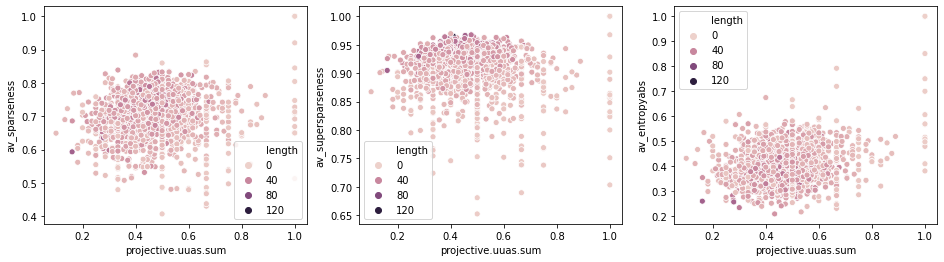

In [11]:
scores['length'] = scores['sentence_length'].astype(float)
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))
sns.scatterplot(x='projective.uuas.sum', y='av_sparseness', hue='length',
                 data=scores, ax=axs[0])
sns.scatterplot(x='projective.uuas.sum', y='av_supersparseness', hue='length',
                 data=scores, ax=axs[1])
sns.scatterplot(x='projective.uuas.sum', y='av_entropyabs', hue='length',
                 data=scores, ax=axs[2])
plt.show()

Average peakiness per sentence doesn't look correlated with accuracy.

In [ ]:
# just out of curiosity, does peakiness correlate with log likelihood? 
# this would be true if sentences which the model predicted very confidently
# it also predicted very markov-ly
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))
sns.scatterplot(x='pseudo_loglik', y='av_sparseness', hue='length',
                 data=scores, ax=axs[0])
sns.scatterplot(x='pseudo_loglik', y='av_supersparseness', hue='length',
                 data=scores, ax=axs[1])
sns.scatterplot(x='pseudo_loglik', y='av_entropyabs', hue='length',
                 data=scores, ax=axs[2])
# fig.colorbar(fig)
plt.show()

## Per word peakiness

For a given word, does the peakiness of the row of CPMIs for that word with all other words in the sentence correlate with the correctness of its prediction?
That is, in a CPMI matrix, are the max values per row more likely to correspond to gold dependencies when the peakiness is high?

In [12]:
wordpair_path = glob.glob(RESULTS_DIR+'wordpair*')[0]
wordpair = pd.read_csv(wordpair_path,dtype={'sentence_index': 'int'})

In [13]:
def insert_nan_diagonal(triu, tril):
    assert triu.shape==tril.shape
    d = triu.shape[0]
    upper = np.zeros((d+1,d+1))
    upper[:-1,1:] = triu
    lower = np.zeros((d+1,d+1))
    lower[1:,:-1] = tril
    matrix = np.nansum(np.dstack((upper, lower)),2)
    np.fill_diagonal(matrix,np.NaN) # should ignore diagonal
    return matrix

def max_is_gold(pmi_row,gold_row):
    assert len(pmi_row)==len(gold_row)
    return bool(gold_row[np.argmax(pmi_row)])

def get_mask_from_df(df_idx, value_column='gold_edge'):
    '''get a boolean map (as nparray) for which edges
    correspond to edges from value_column eg, default 'gold_edge'
    '''
    df_val = df_idx.pivot_table(
        index='i1', columns='i2', values=value_column)
    map_val = df_val.to_numpy()
    map_val = insert_nan_diagonal(map_val, map_val.T)
    return map_val

In [ ]:
# # An example.  dev sentence #31:
# idx=31
# print(f"Sentence {idx}:",
#       f"{int(scores.sentence_length[idx])} PTB tokens;",
#       f"{scores.number_edges[idx]-1} words; {scores.number_edges[idx]} edges")
# print(OBSERVATIONS[idx].sentence)
# df_idx = pd.DataFrame(wordpair[(wordpair.sentence_index==idx)])
# print("Between PTB tokens, the following (absolute value) cpmis:")
# df_idx['pmi_sum_abs'] = abs(df_idx['pmi_tril']) + abs(df_idx['pmi_triu'])
# print(df_idx.pivot_table(index='i1', columns='i2', values='pmi_sum_abs'))

# triu = df_idx.pivot_table(index='i1', columns='i2', values='pmi_triu').to_numpy()
# tril = df_idx.pivot_table(index='i1', columns='i2', values='pmi_tril').to_numpy().T
# matrix = insert_nan_diagonal(triu, tril)
# matrix = abs(np.nansum(np.dstack((matrix, np.transpose(matrix))),2)) # symmetrize and absolute value
# np.fill_diagonal(matrix,np.NaN) # should ignore diagonal
# print(f"symmetrized absolute valued matrix:\n{matrix}")

# # The is_gold matrix shows which edges correspond to gold edges
# df_idx_is_gold = df_idx.pivot_table(index='i1', columns='i2', values='gold_edge')
# print(df_idx_is_gold)
# matrix_is_gold = df_idx_is_gold.to_numpy()
# matrix_is_gold = insert_nan_diagonal(matrix_is_gold,matrix_is_gold.T)
# print(f"symmetrized is gold:\n{matrix_is_gold}\n")

# indices = set(df_idx.i1.unique()).union(df_idx.i2.unique())
# sentence_words = [OBSERVATIONS[idx].sentence[i] for i in indices]

# print(f'{idx}\tword\tsparseness\tentropy_abs\tmax==gold')
# for i, row in enumerate(np.hstack((matrix,matrix_is_gold))):
#     pmi_row, gold_row = np.split(row,2)
#     pmi_row = pmi_row[np.arange(len(pmi_row))!=i] # remove diagonal entries
#     gold_row = gold_row[np.arange(len(gold_row))!=i]
#     print(f'\t{sentence_words[i]}',
#           f'\t{peakiness_sparseness(pmi_row):.6f}',
#           f'\t{peakiness_entropy(pmi_row, absolute=True):.6f}',
#           f'\t{max_is_gold(pmi_row,gold_row)}',
#           sep='')

In [44]:
def get_per_word_peakiness_scores(observations, wordpair):
    data_list = []
    for idx, observation in tqdm(enumerate(observations)):
        df_idx = pd.DataFrame(wordpair[(wordpair.sentence_index == idx)])
        df_idx['pmi_sum_abs'] = abs(
            df_idx['pmi_tril']) + abs(df_idx['pmi_triu'])

        triu = df_idx.pivot_table(
            index='i1', columns='i2', values='pmi_triu').to_numpy()
        tril = df_idx.pivot_table(
            index='i1', columns='i2', values='pmi_tril').to_numpy().T
        matrix = insert_nan_diagonal(triu, tril)
        # symmetrize and absolute value
        matrix = abs(np.nansum(np.dstack((matrix, np.transpose(matrix))), 2))
        np.fill_diagonal(matrix, np.NaN)  # should ignore diagonal

        # The is_gold matrix shows which edges correspond to gold edges
        matrix_is_gold = get_mask_from_df(df_idx, value_column='gold_edge')
        # The is_pmiedge matrices shows which edges correspond to pmi edges
        matrix_is_pmiedge_proj = get_mask_from_df(
            df_idx, value_column='pmi_edge_sum')
        matrix_is_pmiedge_nonproj = get_mask_from_df(
            df_idx, value_column='pmi_edge_nonproj_sum')

        indices = set(df_idx.i1.unique()).union(df_idx.i2.unique())
        sentence_words = [OBSERVATIONS[idx].sentence[i] for i in indices]

        if len(sentence_words) > 0:  # ignore sentences with no edges
            for i, row in enumerate(np.hstack((
                    matrix, matrix_is_gold,
                    matrix_is_pmiedge_proj,matrix_is_pmiedge_nonproj))):
                data = {}
                (pmi_row, gold_row,
                    edge_proj_row, edge_nonproj_row) = np.split(row, 4)
                # remove meaningless diagonal entries from the rows
                pmi_row = pmi_row[np.arange(len(pmi_row)) != i]
                gold_row = gold_row[np.arange(len(gold_row)) != i]
                edge_proj_row = edge_proj_row[np.arange(len(edge_proj_row)) != i]
                edge_nonproj_row = edge_nonproj_row[np.arange(len(edge_nonproj_row)) != i]
                data['sentence_index'] = idx
                data['word'] = sentence_words[i]
                data['peakiness_sparseness'] = peakiness_sparseness(pmi_row)
                data['peakiness_supersparseness'] = peakiness_supersparseness(
                    pmi_row)
                data['peakiness_entropyabs'] = peakiness_entropy(
                    pmi_row, absolute=True)
                data['max_is_gold'] = max_is_gold(pmi_row, gold_row)
                data['pmi_row'] = pmi_row
                data['gold_row'] = gold_row
                data['edge_proj_row'] = edge_proj_row
                data['edge_nonproj_row'] = edge_nonproj_row
                data_list.append(data)
    return data_list

peakiness_scores = pd.DataFrame(
    get_per_word_peakiness_scores(OBSERVATIONS, wordpair))

In [66]:
for df in [peakiness_scores]:    
    df["gold_peakiness_sparseness"] = df.apply(
        lambda x: peakiness_sparseness(x['gold_row']), axis=1)
    df["gold_peakiness_supersparseness"] = df.apply(
        lambda x: peakiness_supersparseness(x['gold_row']), axis=1)
    df["gold_peakiness_entropyabs"] = df.apply(
        lambda x: peakiness_entropy(x['gold_row'], absolute=True), axis=1)

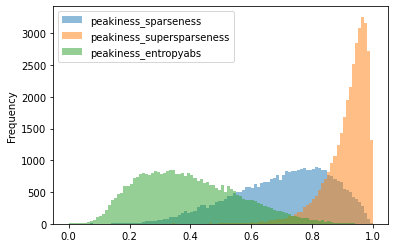

In [88]:
# Histograms of the per word averages of the three peakiness measures.
peakiness_scores[[
    'peakiness_sparseness',
    'peakiness_supersparseness',
    'peakiness_entropyabs']].plot.hist(alpha=0.5,bins=100)
plt.show()

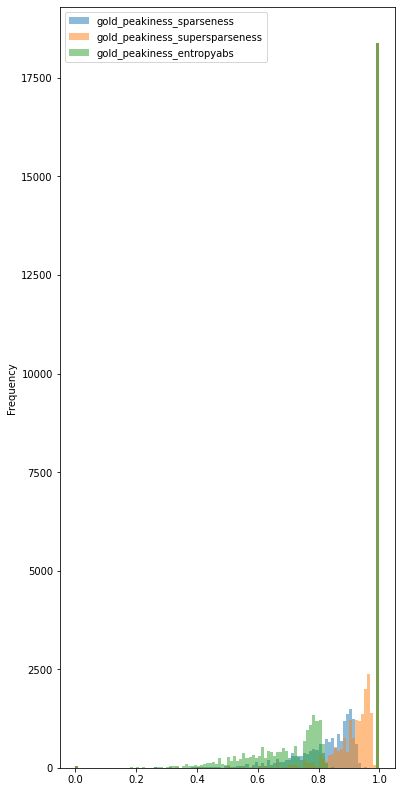

In [100]:
f = peakiness_scores[[
    'gold_peakiness_sparseness',
    'gold_peakiness_supersparseness',
    'gold_peakiness_entropyabs']].plot.hist(alpha=0.5,bins=100,figsize=(6,14))
plt.show()

mean: 0.5862286612418994, std:1.7087556730011673


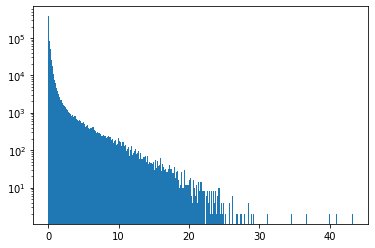

In [117]:
all_cpmi_values = pd.Series(chain(*peakiness_scores.pmi_row.values))
print(f'mean: {all_cpmi_values.mean()}, std:{all_cpmi_values.std()}')
plt.hist(all_cpmi_values, bins=500)
plt.yscale('log')
# plt.xscale('log')
plt.show()

Well, the CPMI values are rather sparse (most values are basically 0).

In [ ]:
# The sentence indices which were skipped 
# check that it's just those with less than two (nonpunctuation) words.
skipped_sentence_indices = sorted(set(range(1700)).difference(set(peakiness_scores.sentence_index.values)))
print(skipped_sentence_indices)

obs_df=pd.DataFrame(OBSERVATIONS)
for index in skipped_sentence_indices:
    obs = obs_df.loc[index]
    print(index, obs.sentence, sep='\t')

### Correlation between peakiness and accuracy

Partition the words in the dataset into two sets, the ones which predict a gold dependency, and the ones which don't.  

That is, letting $\mathrm{row}_w$ denote the row of CPMI scores corresponding to word $w$, 

1. $T = \{ w \in D\mid  i=\arg\max(\mathrm{row_w})$ is the index of a word with which w is in a gold dependency relationship$\}$.
2. $F = \{ w \in D\mid i=\arg\max(\mathrm{row_w})$ is *not* the index of a word with which w is in a gold dependency relationship$\}$.

So we should test correlation
- Alternative hypothesis: the distributions of peakiness over T and F are different (specifically, that T has higher mean than F).

- Null hypothesis: the distributions of peakiness over T and F are the same.

In [366]:
def plot_peakiness_accuracy(df, sparseness_measure, figsize=(7, 5)):
    f, (ax_box1, ax_box2, ax_hist) = plt.subplots(3, sharex=True, 
                                                 gridspec_kw={"height_ratios": (.15,.15,.7)},
                                                 figsize=figsize) 
    vals = [True, False]
    colors = sns.color_palette("deep")
    ax_box = [ax_box1,ax_box2]

    for i in [0,1]:
        sns.boxenplot(df[df["max_is_gold"]==vals[i]][sparseness_measure], color=colors[i],
                      k_depth="tukey", scale='exponential',
                      ax=ax_box[i])
        sns.distplot(
            df[df["max_is_gold"] == vals[i]][sparseness_measure], ax=ax_hist, bins=75, kde=True)

    # # Remove x axis name for the boxplot
    ax_box1.set(xlabel='argmax of row is gold = TRUE')
    ax_box2.set(xlabel='argmax of row is gold = FALSE')
    plt.show()

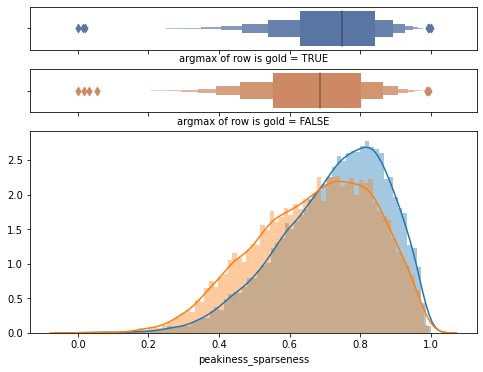

In [367]:
plot_peakiness_accuracy(peakiness_scores, "peakiness_sparseness", figsize=(8, 6))

It looks like the effect isn't very big, but it might very well be significant.  Here are the other two measures, just for comparison. They seem to show the same.

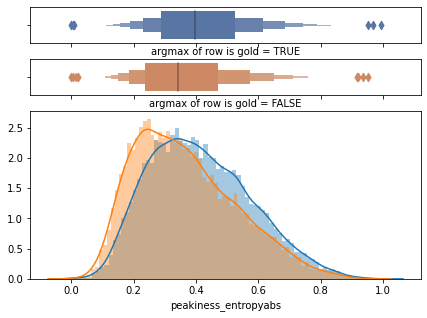

In [368]:
# plot_peakiness_accuracy(peakiness_scores, "peakiness_supersparseness")
plot_peakiness_accuracy(peakiness_scores, "peakiness_entropyabs")

### Statistical significance:

In [31]:
def ttest_ind_report(data1, data2, equal_var=False, alpha=0.05):
    CI = int(100 * (1-alpha))
    ttest = scipy.stats.ttest_ind(data1, data2, equal_var=equal_var)
    N1,N2 = len(data1),len(data2)
    df = (N1 + N2 - 2)
    std1,std2 = data1.std(),data2.std()
    std_N1N2 = sqrt( ((N1 - 1)*(std1)**2 + (N2 - 1)*(std2)**2) / df) 
    diff_mean = data1.mean() - data2.mean()
    margin_of_error = scipy.stats.t.ppf(1-alpha/2, df) * std_N1N2 * sqrt(1/N1 + 1/N2)
    with_ev = 'with' if equal_var else 'without'
    print(f'Independent t-test, {with_ev} equal variance assumption:')
    print(f'\tt-value = {ttest.statistic:4.3f}\n\tp-value = {ttest.pvalue:4.3f}')
    print(f'difference between groups is {diff_mean:3.3f} [+- {margin_of_error:3.3f}],'
          f'(mean [{CI}% CI])')

def mwu_report(x,y):
    mwu = scipy.stats.mannwhitneyu(x, y, alternative="less")
    N_x, N_y = len(x), len(y)
    print("Mann-Whitney U test / Wilcoxon rank-sum test:")
    print(f"\tN_x: {N_x}\t\tN_y:{N_y}")
    print(f"\tmedian x: {x.median():.4f}\tmedian y:{y.median():.4f}")
    print(f"\tU = {mwu.statistic}")
    print(f"\tp = {mwu.pvalue:.4f}")
    mu = 0.5*N_x*N_y
    sigma = sqrt((mu/2 * (N_x+N_y))/12)
    # probability will that a score sampled at random 
    # from one distribution will be greater than a 
    # score sampled from some other distribution.
    print(f"common language effect size: \
    {mwu.statistic/(2*mu):.4f}")

    z= 1.64  # 1.64 for one tailed, sig level 0.05
    # z= 2.33  # 2.33 for one tailed, sig level 0.01
    u_crit = mu - z*sigma - 0.5
    print(f"U_crit = {u_crit}")
    print(f"U < U_crit = significant = {mwu.statistic < u_crit}")
    
true_sparseness = peakiness_scores[peakiness_scores.max_is_gold==True].peakiness_sparseness
false_sparseness = peakiness_scores[peakiness_scores.max_is_gold==False].peakiness_sparseness

mwu_report(false_sparseness,true_sparseness)
print()
ttest_ind_report(false_sparseness,true_sparseness,equal_var=False)

Mann-Whitney U test / Wilcoxon rank-sum test:
	N_x: 15316		N_y:20093
	median x: 0.6867	median y:0.7466
	U = 124740151.0
	p = 0.0000
common language effect size:     0.4053
U_crit = 153090790.39746976
U < U_crit = significant = True

Independent t-test, without equal variance assumption:
	t-value = -31.495
	p-value = 0.000
difference between groups is -0.054 [+- 0.003],(mean [95% CI])


The difference small, but is **very significant** (p<0.001 for both the Wilcoxon rank-sum, and t-test). Likewise for the other measures:

In [ ]:
# true_entropyabs = df[df.max_is_gold==True].peakiness_entropyabs
# false_entropyabs = df[df.max_is_gold==False].peakiness_entropyabs
# true_supersparseness = df[df.max_is_gold==True].peakiness_supersparseness
# false_supersparseness = df[df.max_is_gold==False].peakiness_supersparseness
# print("peakiness measured as entropyabs:")
# ttest_ind_report(true_entropyabs,false_entropyabs,equal_var=False)
# print("\npeakiness measured as supersparseness:")
# ttest_ind_report(true_supersparseness,false_supersparseness,equal_var=False)

In [ ]:
# print("peakiness measured as entropyabs:")
# mwu_report(false_entropyabs, true_entropyabs)
# print("\npeakiness measured as supersparseness:")
# mwu_report(false_supersparseness,true_supersparseness)

### Argmax is right about 57% of the time 

In [32]:
# (note, there are multiple potential edges from a single word, so this is not a good score)
len(peakiness_scores[peakiness_scores["max_is_gold"]==True])/len(peakiness_scores)

0.5674546019373605

In [67]:
peakiness_scores.columns

Index(['sentence_index', 'word', 'peakiness_sparseness',
       'peakiness_supersparseness', 'peakiness_entropyabs', 'max_is_gold',
       'pmi_row', 'gold_row', 'edge_proj_row', 'edge_nonproj_row',
       'pmi_row_max', 'pmi_row_logmax', 'pmi_row_min', 'pmi_row_mean',
       'gold_peakiness_sparseness', 'gold_peakiness_supersparseness',
       'gold_peakiness_entropyabs'],
      dtype='object')

## Show that max pmi and sparseness have to be related

To test the robustness, we will permute all of the edges that are _not_ used by the decoding algorithm (Prim's for nonprojective, or Eisner's for projectives).  That is, for the structures defined by one algorithm, fix CPMI values for wordpairs that are connected by an edge, and shuffle (globally) all CPMI values for wordpairs not connected by an edge.

In [60]:
def replace_from_unused(r, global_list=None, edge_mask=None):
    '''Put shuffled values in unused parts of PMI row. 

    Inputs:
        r: observed row of wordpair_scores df
        global_list: flat list of shuffled PMI scores. will be popped.
        edge_mask: column name for type of edge to preserve (proj or nonproj)
    match list to mask type e.g.: 
        global_list = pmi_unused_proj
        edge_mask = "edge_proj_row"
    '''
    pmi_row = r['pmi_row']
    mask = r[edge_mask]
    return [pmi if mask[i] else global_list.pop() for i, pmi in enumerate(pmi_row)]


# get the pmi scores for edges that are not used
pmi_unused_proj = list(chain(*list(peakiness_scores.apply(
    lambda x: list(compress(x['pmi_row'], (1 - x['edge_proj_row']))),
    axis=1).values)))
pmi_unused_nonproj = list(chain(*list(peakiness_scores.apply(
    lambda x: list(compress(x['pmi_row'], (1 - x['edge_nonproj_row']))),
    axis=1).values)))
pmi_unused_proj_rand = random.sample(pmi_unused_proj, len(pmi_unused_proj))
pmi_unused_nonproj_rand = random.sample(
    pmi_unused_nonproj, len(pmi_unused_nonproj))

peakiness_scores_randproj = peakiness_scores[[
    'sentence_index', 'word', 'gold_row', 'edge_proj_row', 'edge_nonproj_row']].copy()
peakiness_scores_randproj['pmi_row'] = peakiness_scores.apply(
    replace_from_unused,
    axis=1, global_list=pmi_unused_proj_rand, edge_mask='edge_proj_row')

peakiness_scores_randnonproj = peakiness_scores[[
    'sentence_index', 'word', 'gold_row', 'edge_proj_row', 'edge_nonproj_row']].copy()
peakiness_scores_randnonproj['pmi_row'] = peakiness_scores.apply(
    replace_from_unused,
    axis=1, global_list=pmi_unused_nonproj_rand, edge_mask='edge_nonproj_row')

In [68]:
for df in [peakiness_scores_randproj, peakiness_scores_randnonproj]:
    df['peakiness_sparseness'] = df.apply(
        lambda x: peakiness_sparseness(x['pmi_row']), axis=1)
    df['peakiness_supersparseness'] = df.apply(
        lambda x: peakiness_supersparseness(x['pmi_row']), axis=1)
    df['peakiness_entropyabs'] = df.apply(
        lambda x: peakiness_entropy(x['pmi_row'], absolute=True), axis=1)
    df['max_is_gold'] = df.apply(
        lambda x: max_is_gold(x['pmi_row'], x['gold_row']), axis=1)
    df["gold_peakiness_sparseness"] = df.apply(
        lambda x: peakiness_sparseness(x['gold_row']), axis=1)
    df["gold_peakiness_supersparseness"] = df.apply(
        lambda x: peakiness_supersparseness(x['gold_row']), axis=1)
    df["gold_peakiness_entropyabs"] = df.apply(
        lambda x: peakiness_entropy(x['gold_row'], absolute=True), axis=1)

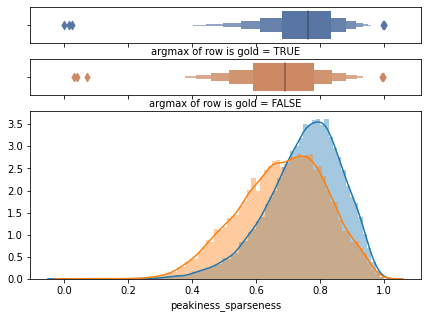

Mann-Whitney U test / Wilcoxon rank-sum test:
	N_x: 17561		N_y:17848
	median x: 0.6919	median y:0.7637
	U = 109971016.0
	p = 0.0000
common language effect size:     0.3509
U_crit = 155925776.77782306
U < U_crit = significant = True

Independent t-test, without equal variance assumption:
	t-value = -50.111
	p-value = 0.000
difference between groups is -0.068 [+- 0.003],(mean [95% CI])


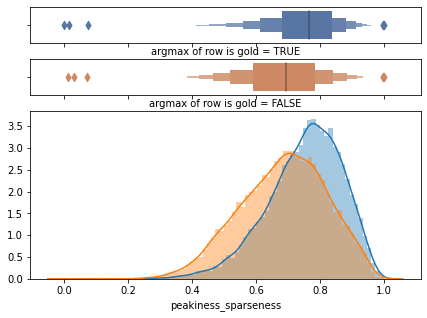

Mann-Whitney U test / Wilcoxon rank-sum test:
	N_x: 17619		N_y:17790
	median x: 0.6933	median y:0.7650
	U = 110055347.0
	p = 0.0000
common language effect size:     0.3511
U_crit = 155932401.06924316
U < U_crit = significant = True

Independent t-test, without equal variance assumption:
	t-value = -50.184
	p-value = 0.000
difference between groups is -0.067 [+- 0.003],(mean [95% CI])


In [369]:
plot_peakiness_accuracy(peakiness_scores_randproj, "peakiness_sparseness")
true_sparseness_randproj = peakiness_scores_randproj[peakiness_scores_randproj.max_is_gold==True].peakiness_sparseness
false_sparseness_randproj = peakiness_scores_randproj[peakiness_scores_randproj.max_is_gold==False].peakiness_sparseness
mwu_report(false_sparseness_randproj,true_sparseness_randproj)
print()
ttest_ind_report(false_sparseness_randproj,true_sparseness_randproj,equal_var=False)

plot_peakiness_accuracy(peakiness_scores_randnonproj, "peakiness_sparseness")
true_sparseness_randnonproj = peakiness_scores_randnonproj[peakiness_scores_randnonproj.max_is_gold==True].peakiness_sparseness
false_sparseness_randnonproj = peakiness_scores_randnonproj[peakiness_scores_randnonproj.max_is_gold==False].peakiness_sparseness
mwu_report(false_sparseness_randnonproj,true_sparseness_randnonproj)
print()
ttest_ind_report(false_sparseness_randnonproj,true_sparseness_randnonproj,equal_var=False)



## Absolute value of PMI

In [63]:
def add_pmi_info_columns(df):
    df["pmi_row_max"] = df.apply(lambda x: np.max(x['pmi_row']),axis=1)
    df["pmi_row_logmax"] = df.apply(lambda x: log(np.max(x['pmi_row'])),axis=1)
    df["pmi_row_min"] = df.apply(lambda x: np.min(x['pmi_row']),axis=1)

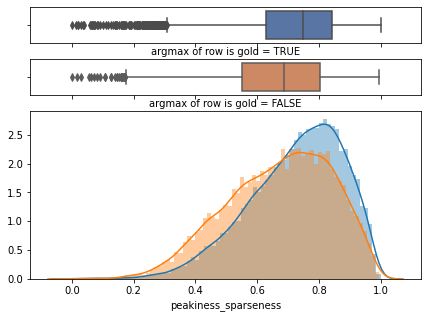

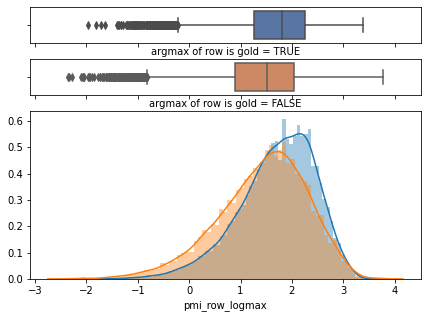

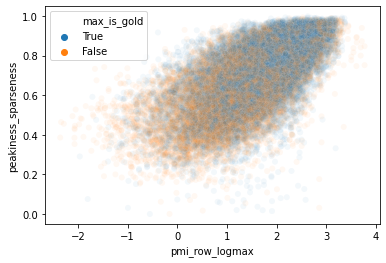

Mann-Whitney U test / Wilcoxon rank-sum test:
	N_x: 15316		N_y:20093
	median x: 4.5846	median y:6.0713
	U = 124318141.5
	p = 0.0000
common language effect size:     0.4040
U_crit = 153090790.39746976
U < U_crit = significant = True

Independent t-test, without equal variance assumption:
	t-value = -24.762
	p-value = 0.000
difference between groups is -1.209 [+- 0.095],(mean [95% CI])
Mann-Whitney U test / Wilcoxon rank-sum test:
	N_x: 15316		N_y:20093
	median x: 0.5268	median y:0.5912
	U = 137777224.0
	p = 0.0000
common language effect size:     0.4477
U_crit = 153090790.39746976
U < U_crit = significant = True

Independent t-test, without equal variance assumption:
	t-value = 10.811
	p-value = 0.000
difference between groups is 0.065 [+- 0.012],(mean [95% CI])
35409


In [107]:
add_pmi_info_columns(peakiness_scores)

plot_peakiness_accuracy(peakiness_scores, "peakiness_sparseness")
plot_peakiness_accuracy(peakiness_scores, "pmi_row_logmax")

sns.scatterplot(data = peakiness_scores,
                x = "pmi_row_logmax", 
                y ='peakiness_sparseness',
                hue ='max_is_gold',
                hue_order = [True, False],
                alpha = 0.05)
plt.show()

true_pmimax = peakiness_scores[peakiness_scores.max_is_gold==True].pmi_row_max
false_pmimax = peakiness_scores[peakiness_scores.max_is_gold==False].pmi_row_max

mwu_report(false_pmimax,true_pmimax)
print()
ttest_ind_report(false_pmimax,true_pmimax,equal_var=False)

true_pmimean = peakiness_scores[peakiness_scores.max_is_gold==True].pmi_row_mean
false_pmimean = peakiness_scores[peakiness_scores.max_is_gold==False].pmi_row_mean

mwu_report(false_pmimean,true_pmimean)
print()
ttest_ind_report(true_pmimean,false_pmimean,equal_var=False)
print(len(peakiness_scores))

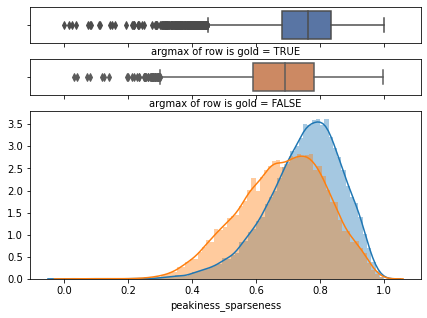

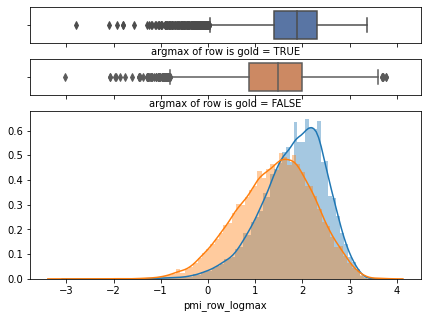

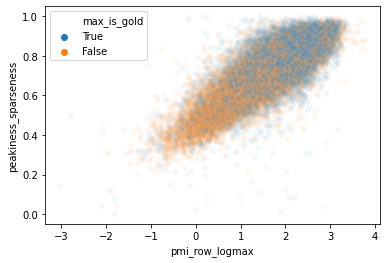

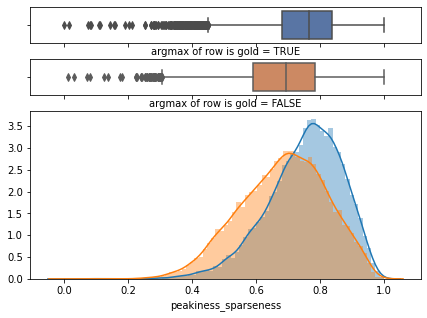

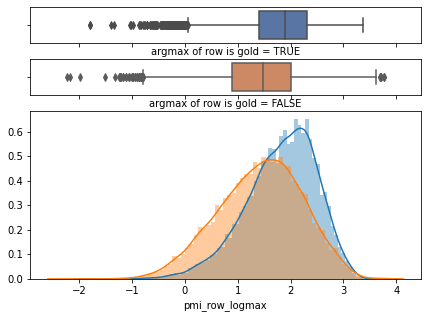

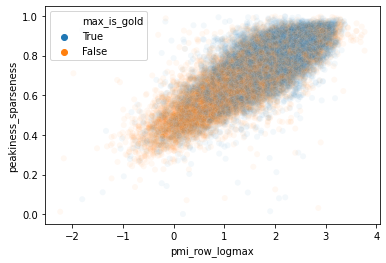

In [108]:
# Abs val max pmi in shuffled data.

add_pmi_info_columns(peakiness_scores_randproj)
plot_peakiness_accuracy(peakiness_scores_randproj, "peakiness_sparseness")
plot_peakiness_accuracy(peakiness_scores_randproj, "pmi_row_logmax")
sns.scatterplot(data = peakiness_scores_randproj,
                x = "pmi_row_logmax", 
                y ='peakiness_sparseness',
                hue ='max_is_gold',
                hue_order = [True, False],
                alpha = 0.05)
plt.show()


add_pmi_info_columns(peakiness_scores_randnonproj)
plot_peakiness_accuracy(peakiness_scores_randnonproj, "peakiness_sparseness")
plot_peakiness_accuracy(peakiness_scores_randnonproj, "pmi_row_logmax")
sns.scatterplot(data = peakiness_scores_randnonproj,
                x = "pmi_row_logmax", 
                y ='peakiness_sparseness',
                hue ='max_is_gold',
                hue_order = [True, False],
                alpha = 0.05)
plt.show()



## PMI magnitude effect interaction with arclength

In [159]:
wordpair['pmi_sum_abs'] = wordpair.apply(lambda x: abs(x['pmi_sum']), axis=1)
print(dft.columns)

Index(['sentence_index', 'i1', 'i2', 'lin_dist', 'w1', 'w2', 'UPOS1', 'UPOS2',
       'XPOS1', 'XPOS2', 'gold_edge', 'relation', 'pmi_sum', 'pmi_triu',
       'pmi_tril', 'pmi_edge_sum', 'pmi_edge_nonproj_sum', 'pmi_edge_triu',
       'pmi_edge_nonproj_triu', 'pmi_edge_tril', 'pmi_edge_nonproj_tril',
       'pmi_edge_none', 'pmi_edge_nonproj_none'],
      dtype='object')


In [163]:
len(wordpair[wordpair.gold_edge==True].pmi_sum_abs)/len(wordpair.pmi_sum_abs)

0.07712709551034556

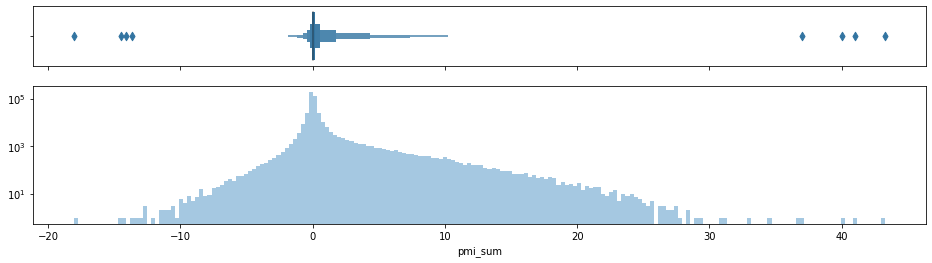

In [383]:
def plot_pmi_hist(df, score, figsize=(7, 5)):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.3,.7)},
                                        figsize=figsize) 

    sns.boxenplot(df[score], ax=ax_box, k_depth="tukey", scale='exponential')
    sns.distplot(df[score], ax=ax_hist, bins=200, kde=False)

    # # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.yscale('log')
    plt.show()
    
plot_pmi_hist(wordpair, score='pmi_sum', figsize=(16, 4))

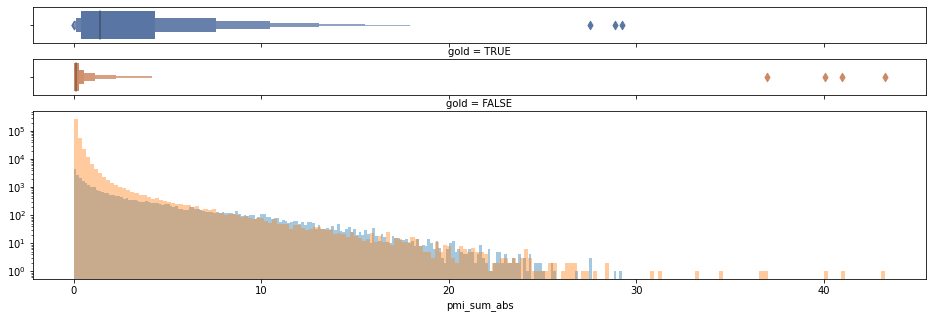

In [372]:
def plot_pmi_accuracy(df, score, figsize=(7, 5)):
    f, (ax_box1, ax_box2, ax_hist) = plt.subplots(3, sharex=True, 
                                                 gridspec_kw={"height_ratios": (.15,.15,.7)},
                                                 figsize=figsize) 
    vals = [True, False]
    colors = sns.color_palette("deep")
    ax_box = [ax_box1,ax_box2]

    for i in [0,1]:
        sns.boxenplot(df[df["gold_edge"]==vals[i]][score], color=colors[i], ax=ax_box[i],
                      k_depth="tukey", scale='exponential')
        sns.distplot(
            df[df["gold_edge"] == vals[i]][score], ax=ax_hist, bins=200, kde=False)

    # # Remove x axis name for the boxplot
    ax_box1.set(xlabel='gold = TRUE')
    ax_box2.set(xlabel='gold = FALSE')
    plt.yscale('log')
    plt.show()
    
plot_pmi_accuracy(wordpair, score='pmi_sum_abs', figsize=(16, 5))

lin_dist == 1:


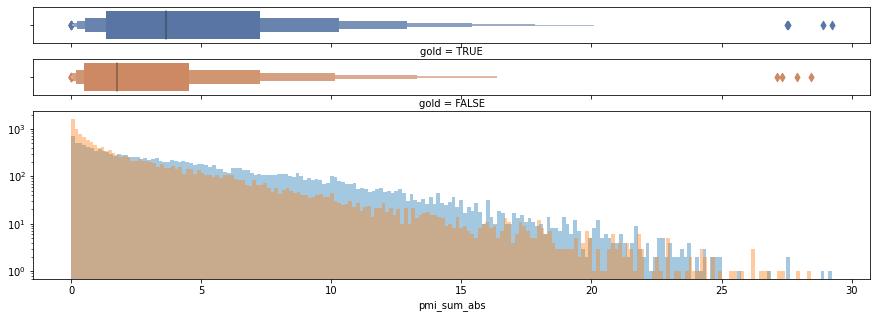

lin_dist > 1:


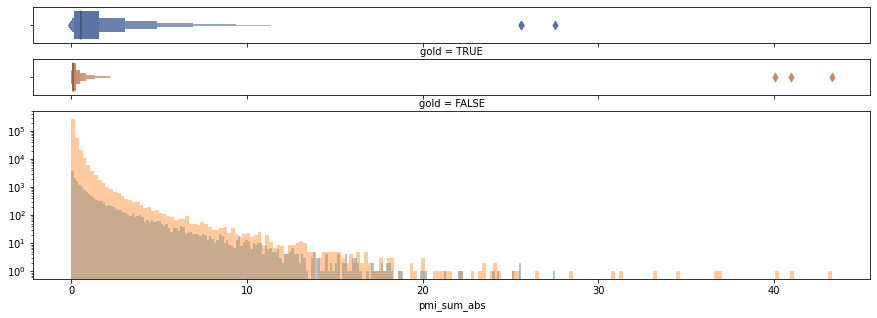

In [344]:
print("lin_dist == 1:")
plot_pmi_accuracy(wordpair[wordpair.lin_dist==1], score='pmi_sum_abs', figsize=(15, 5))
print("lin_dist > 1:")
plot_pmi_accuracy(wordpair[wordpair.lin_dist>1], score='pmi_sum_abs', figsize=(15, 5))

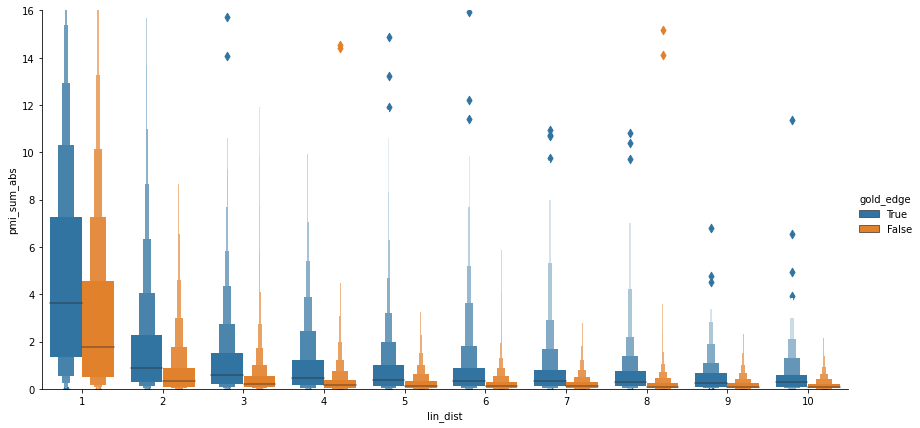

In [388]:
# wordpair[wordpair.lin_dist<=10][['gold_edge','lin_dist','pmi_sum_abs']].boxplot(
#     by='lin_dist',column=['pmi_sum_abs'], figsize=(16,5))
# plt.ylim(0,8)
# plt.show()
sns.catplot(
    kind='boxen', height=6, aspect=2, k_depth="tukey", scale='exponential',
    data=wordpair[wordpair.lin_dist<=10],
    x='lin_dist',y='pmi_sum_abs',hue='gold_edge', hue_order=[True,False])
plt.ylim(0,16)
plt.show()

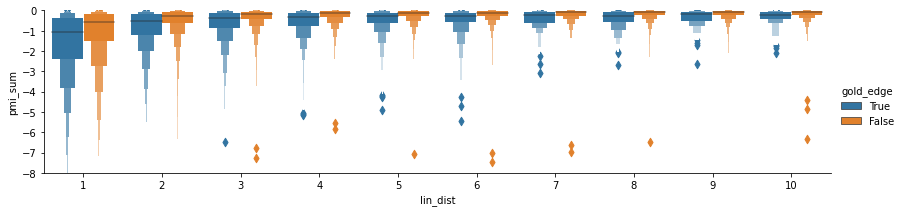

In [370]:
# also, just looking at negative CPMI values, the effect is in the opposite direction, 
# so using the absolute value is justified (or at least, it amplifies the effect)
sns.catplot(
    kind='boxen', height=3, aspect=4, k_depth="tukey", scale='exponential',
    data=wordpair[(wordpair.lin_dist<=10) & (wordpair.pmi_sum < 0)],
    x='lin_dist',y='pmi_sum',hue='gold_edge', hue_order=[True,False])
plt.ylim(-8,0)
plt.show()

The effect is much smaller for shorter arclengths.

In [306]:
# stats to read:
lin_dist_df = wordpair.groupby(['lin_dist','gold_edge'])['pmi_sum_abs'].describe()
lin_dist_df.head(20)

count      mean       std       min       25%       50%  \
lin_dist gold_edge                                                              
1        False      15045.0  3.208628  3.860723  0.000114  0.507965  1.769624   
         True       16179.0  4.876416  4.462767  0.000127  1.328640  3.630647   
2        False      22154.0  0.847228  1.561142  0.000002  0.097903  0.320689   
         True        7539.0  1.829419  2.595742  0.000027  0.277104  0.865233   
3        False      24548.0  0.525162  1.062184  0.000003  0.062743  0.203918   
         True        3702.0  1.230931  1.759979  0.000006  0.188478  0.581029   
4        False      24895.0  0.385184  0.795311  0.000000  0.048882  0.154300   
         True        1980.0  1.114905  1.946032  0.000014  0.148827  0.464384   
5        False      24327.0  0.316287  0.658483  0.000000  0.041881  0.133241   
         True        1116.0  0.923390  1.531018  0.000004  0.128164  0.373014   
6        False      23293.0  0.282031  0.614980  0.000002  0.038554  0.121970   
         True         748.0  0.915489  1.676018  0.000225  0.115265  0.350163   
7        False      22113.0  0.259441  0.637144  0.000000  0.034224  0.109300   
         True         505.0  0.861869  1.613882  0.000673  0.107679  0.335356   
8        False      20903.0  0.231709  0.526697  0.000000  0.032198  0.099995   
         True         376.0  0.772761  1.466596  0.001351  0.103408  0.312346   
9        False      19720.0  0.225899  0.567759  0.000000  0.030578  0.094732   
         True         264.0  0.565400  0.866731  0.001097  0.093817  0.240919   
10       False      18408.0  0.210839  0.558339  0.000000  0.028488  0.089566   
         True         255.0  0.609138  1.092322  0.000021  0.084035  0.287731   

                         75%        max  
lin_dist gold_edge                       
1        False      4.549805  28.422666  
         True       7.265138  29.242697  
2        False      0.895577  31.210739  
         True       2.283889  27.534982  
3        False      0.540489  23.478761  
         True       1.509272  17.420859  
4        False      0.396867  16.883996  
         True       1.221794  25.568487  
5        False      0.340779  20.074392  
         True       1.019308  14.860946  
6        False      0.304835  20.771177  
         True       0.900965  15.949825  
7        False      0.274341  43.286172  
         True       0.795257  10.951279  
8        False      0.251195  17.731985  
         True       0.756338  10.798863  
9        False      0.237830  23.226855  
         True       0.670848   6.798849  
10       False      0.223972  24.077165  
         True       0.597662  11.354290

# Extra stuff : reading data

Check for duplicate sentences.

In [ ]:
# from collections import defaultdict

# def list_duplicates(triple):
#     tally = defaultdict(list)
#     for i,sent,_ in triple:
#         tally[sent].append(i)
#     return ((locs,key) for key,locs in tally.items() 
#                             if len(locs)>1)

# pd.DataFrame(
#     list_duplicates(idx_sentence_matrix_triples),
#     columns=['indices','sentence']).style.set_properties(
#     **{'text-align': 'left', 'display.max_colwidth': -1}).set_table_styles(
#     [ dict(selector='th', props=[('text-align', 'left')] ) ])